# Chest X-Ray Classification using CNN (Pneumonia Detection)


In [ ]:
#	Downloaded the Chest X-Ray Dataset
# (https://www.kaggle.com/datasets/vivek468/beginner-chest-xray-image-classification).

In [1]:
# Step 1: Import Required Libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229])
    ]),
    'pred': transforms.Compose([   # New key for 'pred'
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229])
    ])
}


In [5]:
data_dir = r'E:\Notes\SAIT Integrated AI\Semester 2\Computer Vision\Lab_2\chest_xray'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'pred', 'test']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True)
               for x in ['train', 'pred', 'test']}

# Optionally, if you have code that explicitly uses 'val', change it to 'pred'
class_names = image_datasets['train'].classes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [6]:
# Step 4: Load Pretrained Model
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

e:\Notes\SAIT Integrated AI\Semester 2\Computer Vision\Lab_2\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Notes\SAIT Integrated AI\Semester 2\Computer Vision\Lab_2\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Step 5: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [8]:
# Step 6: Train the Model
import numpy as np

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
        epoch_loss = running_loss / total
        epoch_acc = correct.double() / total
        print(f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
train_model(model, dataloaders, criterion, optimizer)

Epoch 1/10
Loss: 0.3877, Acc: 0.8272
Epoch 2/10
Loss: 0.3651, Acc: 0.8458
Epoch 3/10
Loss: 0.3591, Acc: 0.8462
Epoch 4/10
Loss: 0.3451, Acc: 0.8547
Epoch 5/10
Loss: 0.3612, Acc: 0.8472
Epoch 6/10
Loss: 0.3592, Acc: 0.8477
Epoch 7/10
Loss: 0.3583, Acc: 0.8459
Epoch 8/10
Loss: 0.3323, Acc: 0.8625
Epoch 9/10
Loss: 0.3500, Acc: 0.8507
Epoch 10/10
Loss: 0.3358, Acc: 0.8580


In [9]:
# Step 7: Evaluate on Test Data
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels)
        total += labels.size(0)
accuracy = correct.double() / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9500


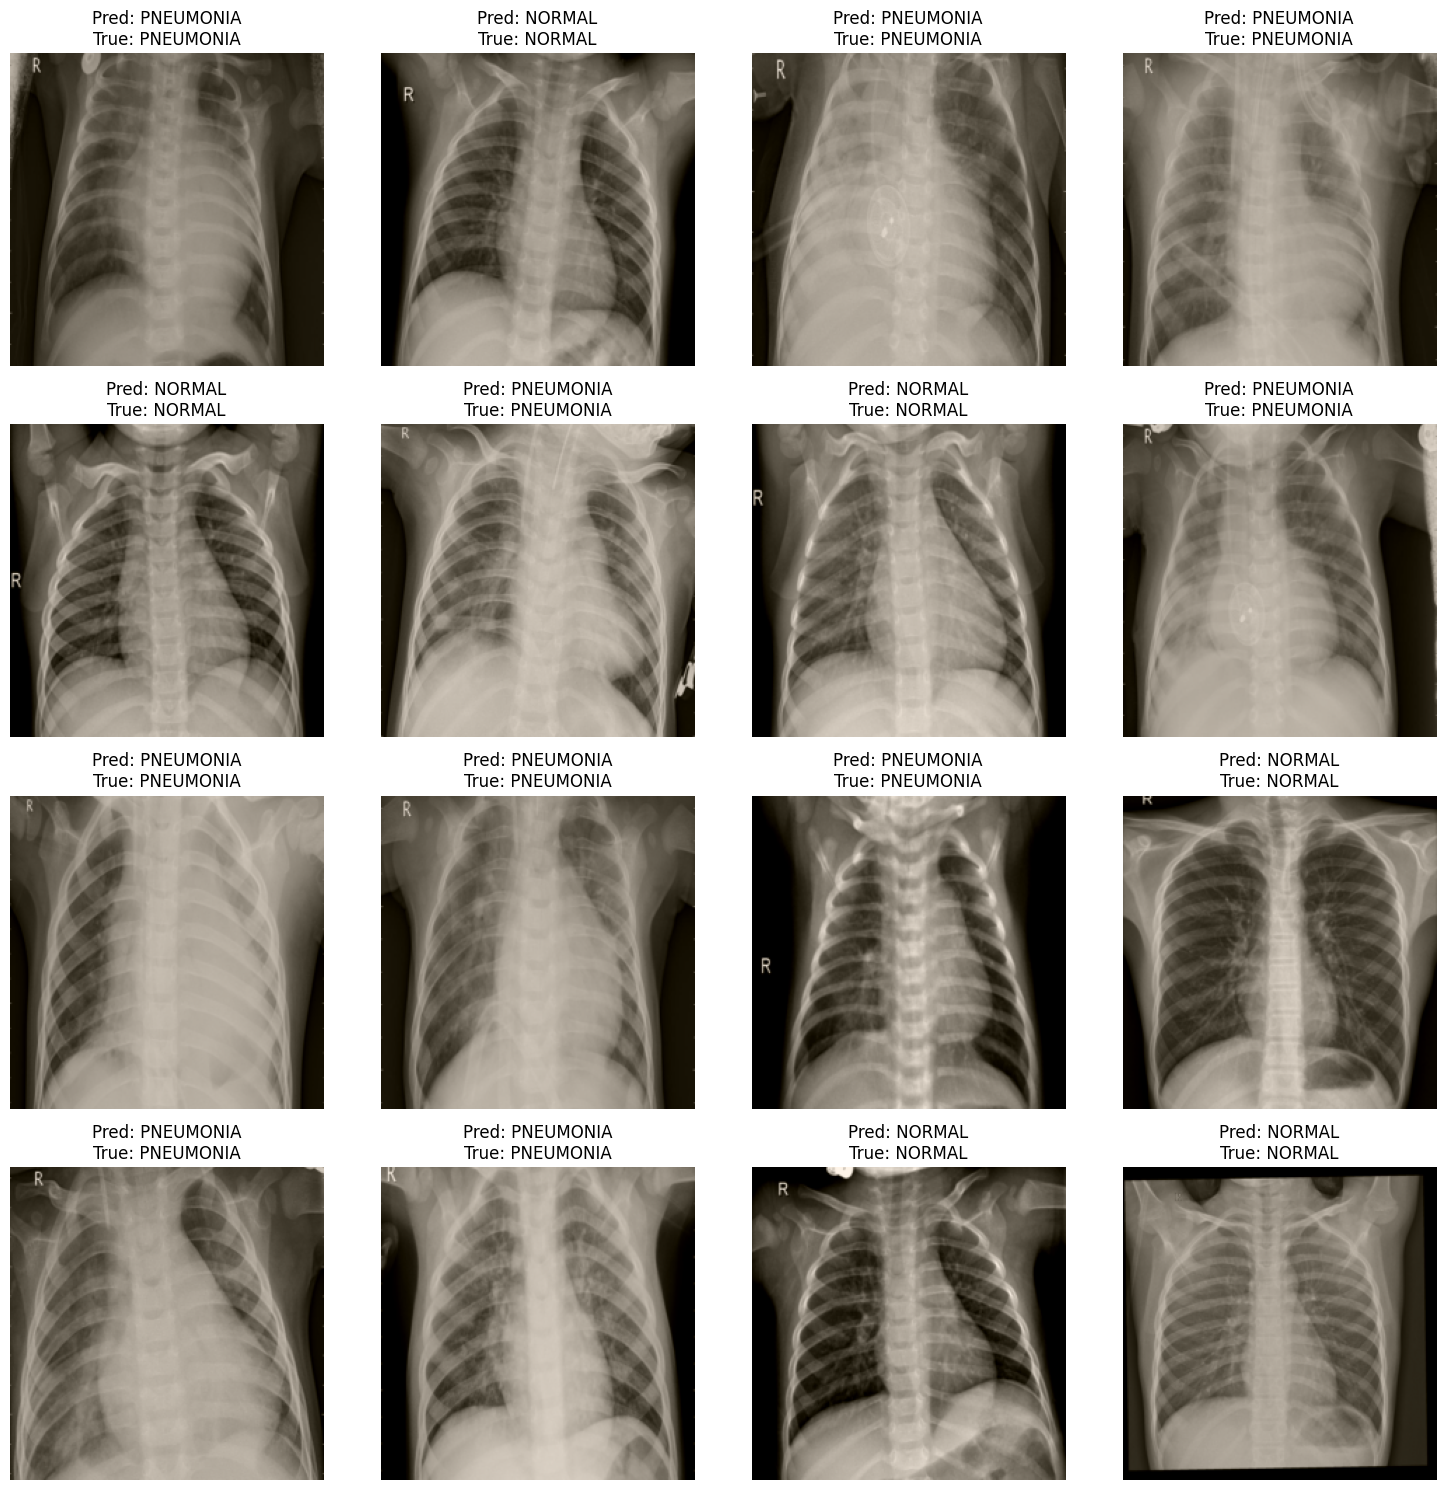

In [15]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

# Set how many images you want to plot.
num_images_to_show = 16  
all_inputs = []
all_labels = []
all_preds = []
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    all_inputs.append(inputs.cpu())
    all_labels.append(labels)
    all_preds.append(preds.cpu())
    # Check if we have collected enough images.
    if sum(x.size(0) for x in all_labels) >= num_images_to_show:
        break

# Concatenate all the batches.
all_inputs = torch.cat(all_inputs, dim=0)
all_labels = torch.cat(all_labels, dim=0)
all_preds = torch.cat(all_preds, dim=0)

# Select only the first num_images_to_show images.
all_inputs = all_inputs[:num_images_to_show]
all_labels = all_labels[:num_images_to_show]
all_preds = all_preds[:num_images_to_show]

# Set grid size: For 16 images, a 4x4 grid works fine. Adjust cols if you change num_images_to_show.
cols = 4
rows = (num_images_to_show + cols - 1) // cols

plt.figure(figsize=(15, 15))
for idx in range(num_images_to_show):
    plt.subplot(rows, cols, idx + 1)
    imshow(all_inputs[idx], title=f"Pred: {class_names[all_preds[idx]]}\nTrue: {class_names[all_labels[idx]]}")
plt.tight_layout()
plt.show()